# Predict Blooming Date with scikit-learn

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import dataset
data = pd.read_csv('hirosaki_temp_cherry_bloom.csv')
data.head()

,date,temperature,flower_status
0,1997/1/1,2.9,NaN
1,1997/1/2,2.2,NaN
2,1997/1/3,-1.6,NaN
3,1997/1/4,0.2,NaN
4,1997/1/5,-0.4,NaN


## Split date to year, month and day

In [3]:
year = []
month = []
day = []
date = data.iloc[:,0].values
for i in range(len(date)):
    str = date[i]
    temp = str.split('/', 1)
    year.append(int(temp[0]))
    month.append(int(temp[1].split('/', 1)[0]))
    day.append(int(temp[1].split('/', 1)[1]))
    
data['year'] = year
data['month'] = month
data['day'] = day

data.drop('date', axis = 1, inplace = True)       # date, gün, ay, yıl verilerine ayrıldı. Artık date'e gerek yok
data

,temperature,flower_status,year,month,day
0,2.9,NaN,1997,1,1
1,2.2,NaN,1997,1,2
2,-1.6,NaN,1997,1,3
3,0.2,NaN,1997,1,4
4,-0.4,NaN,1997,1,5
...,...,...,...,...,...
8395,-0.2,NaN,2019,12,27
8396,-1.3,NaN,2019,12,28
8397,-0.6,NaN,2019,12,29
8398,1.8,NaN,2019,12,30


## Missing Values

In [4]:
data.isnull().sum()

temperature         0
flower_status    8331
year                0
month               0
day                 0
dtype: int64

In [5]:
flower_status = data.iloc[:, 1:2].values
data.drop('flower_status', axis = 1, inplace = True)
for i in range(len(flower_status)):
    month, day = data['month'][i], data['day'][i]
    if month == 1 and day == 1:
        status = 0                                 # Before Blooming
    else:
        if flower_status[i] == "bloom":            
            status = 1                             # Bloom
        elif flower_status[i] == "full":           
            status = 2                             # Full Bloom
        elif flower_status[i] == "scatter":        
            status = 3                             # Scatter
    flower_status[i] = status
    
data['flower_status'] = flower_status
data

,temperature,year,month,day,flower_status
0,2.9,1997,1,1,0
1,2.2,1997,1,2,0
2,-1.6,1997,1,3,0
3,0.2,1997,1,4,0
4,-0.4,1997,1,5,0
...,...,...,...,...,...
8395,-0.2,2019,12,27,3
8396,-1.3,2019,12,28,3
8397,-0.6,2019,12,29,3
8398,1.8,2019,12,30,3


## Data Preprocessing

In [6]:
# Extract Data
for i in range(len(data)):
    month = data['month'][i]
    if month != 3 and month != 4 and month != 5:    #  and month != 6
        data.drop([i], axis = 0, inplace = True)
        
# Reindexing
data = data.rename(index = {j: i for i, j in enumerate(data.index)})
data

,temperature,year,month,day,flower_status
0,2.4,1997,3,1,0
1,-2.4,1997,3,2,0
2,-4.0,1997,3,3,0
3,-1.1,1997,3,4,0
4,0.3,1997,3,5,0
...,...,...,...,...,...
2111,24.0,2019,5,27,3
2112,19.0,2019,5,28,3
2113,16.1,2019,5,29,3
2114,19.0,2019,5,30,3


In [7]:
# Take cumulative temperature and add data column
newdata = []
accumulated_temp = 0
for i in range(len(data)):
    month, day = data['month'][i], data['day'][i]
    if month == '4' and day == '1':
        accumulated_temp = 0
    temp = data['temperature'][i]
    accumulated_temp += temp
    status = data['flower_status'][i]
    row = {'month':month, 'day':day, 'temperature':temp, 'temp_accum':accumulated_temp, 'flower_status':status}
    newdata.append(row)
newdata = pd.DataFrame(newdata)
newdata

,month,day,temperature,temp_accum,flower_status
0,3,1,2.4,2.4,0
1,3,2,-2.4,0.0,0
2,3,3,-4.0,-4.0,0
3,3,4,-1.1,-5.1,0
4,3,5,0.3,-4.8,0
...,...,...,...,...,...
2111,5,27,24.0,17950.3,3
2112,5,28,19.0,17969.3,3
2113,5,29,16.1,17985.4,3
2114,5,30,19.0,18004.4,3


## Data Slicing and Reshaping

In [8]:
x = newdata.drop(['flower_status'], axis = 1)
y = newdata.iloc[:, 4:].values
x = x.astype('float32')                      # temperature, day, month, year
y = y.astype('int32')                        # flower_status

### Feature Scaling

In [9]:
from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(x)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_robust, y, test_size = 0.33, random_state = 0)

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(random_state = 0)

# Train logistic regression model 
logr.fit(x_train, y_train.ravel())

LogisticRegression(random_state=0)

In [12]:
# Make Prediction
y_pred = logr.predict(x_test)

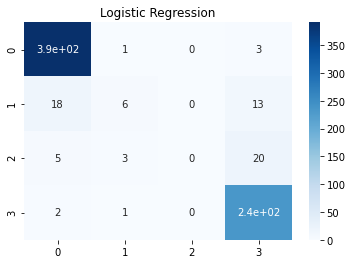

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       395
           1       0.55      0.16      0.25        37
           2       0.00      0.00      0.00        28
           3       0.87      0.99      0.92       239

    accuracy                           0.91       699
   macro avg       0.59      0.53      0.53       699
weighted avg       0.86      0.91      0.87       699

accuracy : 0.90558


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("Logistic Regression")
plt.show()

# Classification Report
clfReport = classification_report(y_test, y_pred, zero_division = 0)
print(clfReport)

score = accuracy_score(y_test, y_pred)
print('accuracy :', '{:.5f}'.format(score))

# K-NN Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski') # 6

# Train K-NN Model
knn.fit(x_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=6)

In [15]:
# Make a Prediction
y_pred = knn.predict(x_test)

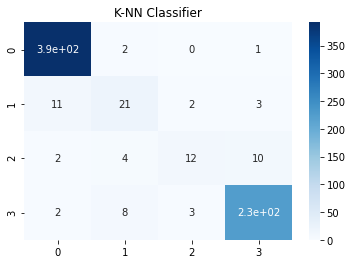

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       395
           1       0.60      0.57      0.58        37
           2       0.71      0.43      0.53        28
           3       0.94      0.95      0.94       239

    accuracy                           0.93       699
   macro avg       0.80      0.73      0.76       699
weighted avg       0.93      0.93      0.93       699

accuracy : 0.93133


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("K-NN Classifier")
plt.show()

# Classification Report
clfReport = classification_report(y_test, y_pred, zero_division = 0)
print(clfReport)

score = accuracy_score(y_test, y_pred)
print('accuracy :', '{:.5f}'.format(score))

# SVM Classifier

In [17]:
from sklearn.svm import SVC

svc = SVC(kernel = 'rbf')         # rbf, sigmoid, poly

# Train SVM classifier model
svc.fit(x_train, y_train.ravel())

SVC()

In [18]:
y_pred = svc.predict(x_test)

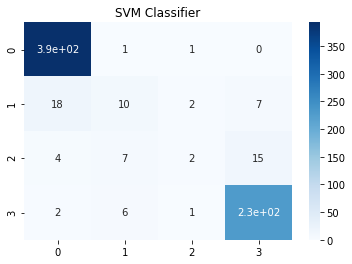

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       395
           1       0.42      0.27      0.33        37
           2       0.33      0.07      0.12        28
           3       0.91      0.96      0.94       239

    accuracy                           0.91       699
   macro avg       0.65      0.57      0.59       699
weighted avg       0.88      0.91      0.89       699

accuracy : 0.90844


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title("SVM Classifier")
plt.show()

# Classification Report
clfReport = classification_report(y_test, y_pred, zero_division = 0)
print(clfReport)

score = accuracy_score(y_test, y_pred)
print('accuracy :', '{:.5f}'.format(score))